In [1]:
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Introduction 

Winemaking is a large global industry, with over 330 billion USD worth of wine sold in 2020. Cheap wine can be around 15 USD per bottle, with more expensive ones fetching 500 USD or more. Wine price is dictated partly by its quality, which is in turn linked to factors like sugar content, acidity, alcohol content, and many more. Below is a dataset with data about the quality of red wine, collected in 2009. 

In [2]:
red<- read_csv2("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv") 
red

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (5): volatile acidity, citric acid, chlorides, density, sulphates
dbl (2): total sulfur dioxide, quality

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
74,0.7,0,19,0.076,11,34,0.9978,351,0.56,94,5
78,0.88,0,26,0.098,25,67,0.9968,32,0.68,98,5
78,0.76,0.04,23,0.092,15,54,0.997,326,0.65,98,5
112,0.28,0.56,19,0.075,17,60,0.998,316,0.58,98,6
74,0.7,0,19,0.076,11,34,0.9978,351,0.56,94,5
74,0.66,0,18,0.075,13,40,0.9978,351,0.56,94,5
79,0.6,0.06,16,0.069,15,59,0.9964,33,0.46,94,5
73,0.65,0,12,0.065,15,21,0.9946,339,0.47,10,7
78,0.58,0.02,2,0.073,9,18,0.9968,336,0.57,95,7


This dataset contains many different variables that play a part in determining the quality of red wine. For this model, we will be focusing on how citric acid, residual sugar, and alcohol content affect the rating of red wine. Below, we will select those variables and create our training and testing sets. 

In [10]:
red_data <- red |>
            mutate(quality = as_factor(quality))
colnames(red_data) <- make.names(colnames(red_data))

red_data_scaled<-red_data |>
                mutate(citric.acid=as.numeric(citric.acid)) |>
                mutate(scaled_citric_acid=scale(citric.acid,center=TRUE),
                        scaled_residual_sugar=scale(residual.sugar,center=TRUE),
                        scaled_alcohol=scale(alcohol,center=TRUE))

red_split<-initial_split(red_data_scaled, prop=0.75, strata=quality)
red_train<-training(red_split) 
red_test<-testing(red_split) 

red_train_set<-red_train |>
                select(c(citric.acid,residual.sugar,alcohol,scaled_citric_acid,scaled_residual_sugar,scaled_alcohol,quality))
red_test_set<-red_test |>
                select(c(citric.acid,residual.sugar,alcohol,scaled_citric_acid,scaled_residual_sugar,scaled_alcohol,quality))
red_train_set




citric.acid,residual.sugar,alcohol,scaled_citric_acid,scaled_residual_sugar,scaled_alcohol,quality
<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
0.00,26,98,-1.39103710,-0.01701753,-0.04317968,5
0.00,19,94,-1.39103710,-0.18264984,-0.04317968,5
0.00,18,94,-1.39103710,-0.20631160,-0.04317968,5
0.06,16,94,-1.08303069,-0.25363512,-0.04317968,5
0.08,18,92,-0.98036188,-0.20631160,-0.04317968,5
0.36,61,105,0.45700139,0.81114405,-0.04317968,5
0.00,16,99,-1.39103710,-0.25363512,-0.04317968,5
0.29,16,91,0.09766057,-0.25363512,-0.04317968,5
0.18,38,92,-0.46701786,0.26692358,-0.04317968,5


The above training set contains the data that we will use to train our model. 

! Fold2: internal:
  No observations were detected in `truth` for level(s): '3'
  Computation will proceed by ignoring those levels.



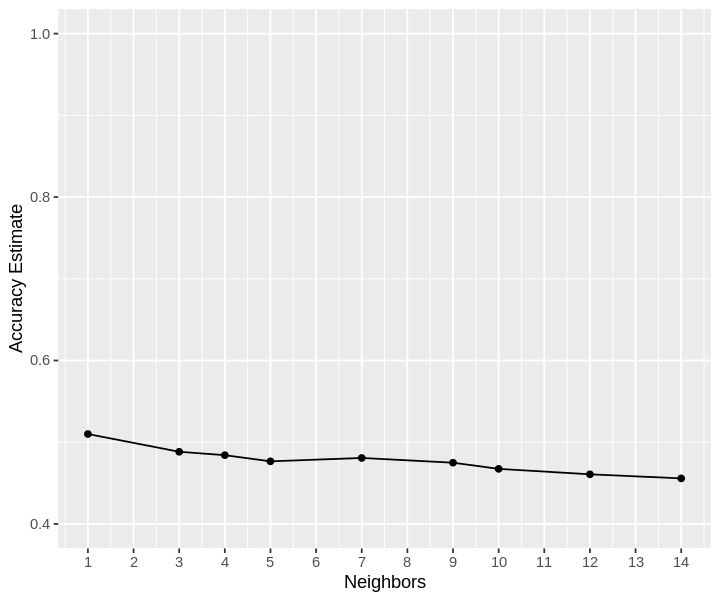

In [16]:
counts<-red_train_set |>
        group_by(quality) |>
        summarize(n=n())
counts

counts_sugar<-red_train_set |>
        group_by(residual.sugar) |>
        summarize(n=n())

quality,n
<fct>,<int>
3,7
4,41
5,508
6,478
7,149
8,15
